In [5]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from PIL import Image
import os

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
# %%
import os
import sys
import cv2
import pdb
import json
import copy
import torch
import pickle
import imageio
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from matplotlib.animation import FuncAnimation
from deap import base, creator, tools, algorithms


from tqdm import tqdm
from typing import Tuple
from math import sin, cos, tan
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R


ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import wisp
from wisp.core import RenderBuffer, Rays
# %%
from inerf_utils import *
from wisp.datasets import SampleRays
from wisp.framework import WispState
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline
from kaolin.render.camera import Camera, blender_coords, opengl_coords
from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
    pipeline = torch.load(args.pretrained)
    pipeline.to(extra_args['device'])
    scene_state = WispState()
    return pipeline

def gen_camera(pose, focal, w, h, far, extra_args):
    view_matrix = torch.zeros_like(pose)
    view_matrix[:3, :3] = pose[:3, :3].T
    view_matrix[:3, -1] = torch.matmul(-view_matrix[:3, :3], pose[:3, -1])
    view_matrix[3, 3] = 1.0

    x0 = 0.0
    y0 = 0.0
    camera = Camera.from_args(
        view_matrix=view_matrix,
        focal_x=focal,
        focal_y=focal,
        width=w,
        height=h,
        far=far,
        near=0.0,
        x0=x0,
        y0=y0,
        dtype=torch.float32,
        device=extra_args['device']
    )
    camera.change_coordinate_system(blender_coords())
    return camera

def gen_rays_only(camera):
    ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
    rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
    rays = Rays.stack(rays)
    return rays

def create_vid(imgs, path, fps=10):
    W,H = imgs[0].shape[1], imgs[0].shape[0]
    out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (W,H))
    for i in range(len(imgs)):
        img = imgs[i]
        img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)
    out.release()

W, H = 200, 200
# W, H = 800, 800

fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
z_near = 0.0
z_far = 10.0
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 3e-3,
  'epochs': 60,
  'wait_epochs': 12
}

def get_c2w_from_pos(camera_position: np.ndarray, lookat: np.ndarray) -> torch.tensor:
    new_z = (camera_position - lookat)
    new_z = new_z / np.linalg.norm(new_z)

    z = np.array((0,0,1))
    new_y = z - np.dot(z, new_z) * new_z

    if (np.linalg.norm(new_y) == 0):
        new_y = np.array((0,1,0))
    new_y = new_y / np.linalg.norm(new_y)

    r, _ = R.align_vectors([(0,1,0), (0,0,1)], [new_y, new_z])
    c2w = torch.eye(4)
    c2w[:3,:3] = torch.tensor(np.linalg.inv(r.as_matrix()))
    c2w[:3,-1] = (torch.tensor(camera_position) * translation_scale) + translation_offset
    return c2w

def get_c2w_from_pos2(camera_position: np.ndarray, lookat: np.ndarray) -> torch.tensor:
    new_z = (camera_position - lookat)
    new_z = new_z / np.linalg.norm(new_z)

    new_y = np.cross(new_z, np.array((1,0,0)))

    r, _ = R.align_vectors([(0,1,0), (0,0,1)], [new_y, new_z])
    c2w = torch.eye(4)
    c2w[:3,:3] = torch.tensor(np.linalg.inv(r.as_matrix()))
    c2w[:3,-1] = (torch.tensor(camera_position) * translation_scale) + translation_offset
    return c2w


def camera_obj_from_c2w(c2w: np.ndarray):
    camera = gen_camera(c2w, extra_args['focal'], W, H, extra_args['z_far'], extra_args)
    return camera

# %%
render_batch = 40000
def render_pipeline(pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(render_batch):
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx)
    return rb

# %%
def get_images(cam, pipelines) -> np.ndarray:
    all_rgbs = np.zeros((len(pipelines), H, W, 3), dtype=float)
    for i, pipeline in enumerate(pipelines):
        all_rgbs[i,...] = get_image(cam, pipeline)[0]
    mean = np.mean(all_rgbs, axis = 0)
    var = np.mean(np.var(all_rgbs, axis = 0), axis=2)
    return mean, var

def get_image(cam, pipeline) -> Tuple[np.ndarray, np.ndarray]:
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = render_pipeline(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    return rgb, alpha


# %%
argv_base = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    '--pretrained=path_to_model',
    '--valid-only'
]

base_scale = 6
base_offset = torch.tensor([0, -0.6, -0.15])
translation_scale = torch.tensor(base_scale/1.25)
translation_offset = translation_scale*base_offset


In [8]:
model_name = 'workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20'
output_dir = 'results'



In [59]:
root_dir = '/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/' + model_name + '/'
pipelines = []
for i in range(1,6):
    model_dir = os.path.join(root_dir, f"model_{i}")
    model_path = os.path.join(model_dir, list(sorted(os.listdir(model_dir)))[0], "model.pth")
    print(model_path)
    sys.argv[1:] = argv_base
    sys.argv[2] = sys.argv[2].replace("path_to_model", model_path)
    print(sys.argv[2])
    args, args_dict = parse_args()
    pipeline = make_model(args, args_dict, extra_args, None, None)
    pipelines.append(pipeline)

centre = np.array((0,0.6,0.15))
img_means = []

/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_17/model_1/20230924-204027/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_17/model_1/20230924-204027/model.pth
/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_17/model_2/20230924-204207/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_17/model_2/20230924-204207/model.pth
/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_17/model_3/20230924-204349/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nob

In [53]:
centre = np.array((0,0.6,0.15))
img_means = []
r = 3
theta = 0

x = centre[0] + r*np.cos(theta)
y = centre[1] + r*np.sin(theta)
z = centre[2]


In [54]:
# c2w = torch.tensor([
#     [
#       0.9994663454314965,
#       0.03035243558845697,
#       -0.012072862281044682,
#       0.0
#     ],
#     [
#       -0.010403585287715865,
#       -0.054565258683486315,
#       -0.9984560070218244,
#       0.0
#     ],
#     [
#       -0.030964330494453175,
#       0.9980487774646352,
#       -0.054220365531573785,
#       0.0
#     ],
#     [
#       0.0021715560715285798,
#       -0.13712720649007246,
#       0.29971321182031285,
#       1.0
#     ]
#   ])

# c2w[..., :3, 3] *= translation_scale
# c2w[..., :3, 3] += translation_offset


In [55]:
# x, y, z = 0.03, 0.55, 0.4
# x, y, z = 0.5, 0.2, 0.3
x, y, z = 0.3, 0.5, 0.15

In [56]:
# c2w = get_c2w_from_pos(np.array((0.1, 0.4, 0.4)), centre)
# c2w = get_c2w_from_pos(np.array((0, 0.6, 0.4)), centre)
# c2w = get_c2w_from_pos(np.array((x,y,z)), centre)
c2w = get_c2w_from_pos(np.array((x,y,z)), np.array((0,0.5,0.15)))
cam = camera_obj_from_c2w(c2w)
mean, var = get_images(cam, pipelines)

/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([640000, 1])

In [57]:
# cam.intrinsics.named_params()
c2w_unscaled = c2w.clone()
c2w_unscaled[..., :3, 3] -= translation_offset
c2w_unscaled[..., :3, 3] /= translation_scale
c2w_unscaled

tensor([[0.0000, 0.0000, 1.0000, 0.3000],
        [1.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 1.0000, 0.0000, 0.1500],
        [0.0000, 0.0000, 0.0000, 1.0000]])

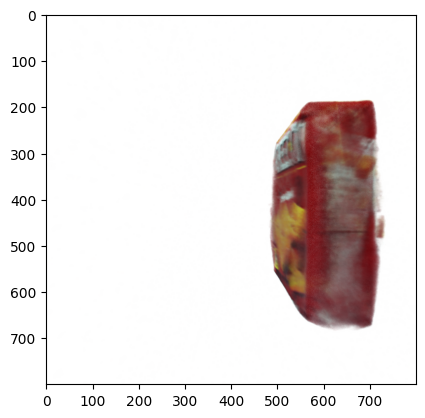

In [58]:
plt.imshow(mean)

In [13]:
rays = gen_rays_only(cam)
rays = rays.reshape((rays.shape[0]**2, -1))
rb = render_pipeline(pipeline, rays, lod_idx=None)
rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
depth = rb.depth.detach().cpu().numpy().reshape((H, W))
alpha = rb.alpha.detach().cpu().numpy().reshape((H, W)) 
# depth[depth == 0] = 0.4 * 6 / 1.25
# depth = (0.4 * 6 / 1.25) - depth

# depth[alpha <= 0.1] = z * 6 / 1.25
depth[alpha <= 0.1] = 10

depth[alpha > 0.1] = depth[alpha > 0.1] / alpha[alpha > 0.1]

In [14]:
folder = "/home/saptarshi/dev/anygrasp/anygrasp_sdk/grasp_detection/cheezit6"
os.makedirs(folder, exist_ok=True)
print(os.listdir(folder))
print(folder)
cv2.imwrite(f'{folder}/color.png', cv2.cvtColor((rgb*255.).astype(np.uint8), cv2.COLOR_RGB2BGR))
Image.fromarray((depth * 1000 / 6 * 1.25).astype(np.int32), 'I').save(f'{folder}/depth.png')

['color.png', 'depth.png']
/home/saptarshi/dev/anygrasp/anygrasp_sdk/grasp_detection/cheezit6


In [8]:
# px 3d bar plot of depth
depth2 = np.array(Image.open('/home/saptarshi/dev/anygrasp/anygrasp_sdk/grasp_detection/example_data/depth.png'))
W2 = 1280
H2 = 720
import plotly.graph_objects as go
xy = np.meshgrid(np.arange(0, W), np.arange(0, H))
xy2 = np.meshgrid(np.arange(0, W2), np.arange(0, H2))

In [48]:
depth2.mean()

405.52477973090276

In [49]:
# fx, fy = 800, 800
fx, fy = 514.66662, 514.66662
cx, cy = 400, 400
scale = 1000


xmin, xmax = -10, 10
ymin, ymax = -10, 10
zmin, zmax = -10, 10
lims = [xmin, xmax, ymin, ymax, zmin, zmax]

# get point cloud
xmap, ymap = np.arange(depth.shape[1]), np.arange(depth.shape[0])
xmap, ymap = np.meshgrid(xmap, ymap)

angles = np.arctan(np.power(np.power(xmap - cx, 2) + np.power(ymap - cy, 2), 0.5)/fx)
points_z = depth * np.cos(angles) / scale

In [50]:
fig = go.Figure(data=[go.Surface(z=-depth, x=xy[0], y=xy[1])])
fig2 = go.Figure(data=[go.Surface(z=depth2, x=xy2[0], y=xy2[1])])
fig_depth1 = go.Figure(data=[go.Surface(z=alpha, x=xy[0], y=xy[1])])
fig_pointsz = go.Figure(data=[go.Surface(z=-points_z, x=xy[0], y=xy[1])])
fig_coses = go.Figure(data=[go.Surface(z=np.cos(angles), x=xy[0], y=xy[1])])
# fig2

In [51]:
# np.quantile(depth, 0.)

In [52]:
# save fig as html 
fig.write_html("results/depth.html")
fig2.write_html("results/depth2.html")

fig_depth1.write_html("results/alpha.html")
fig_pointsz.write_html("results/points_z.html")
fig_coses.write_html("results/coses.html")

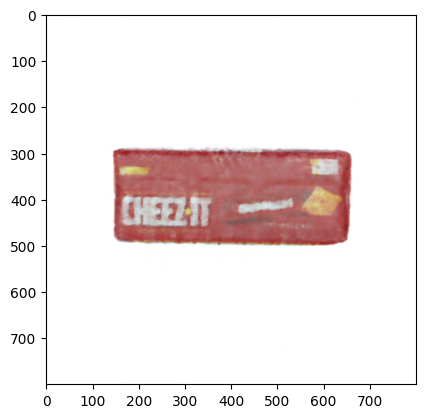

In [17]:
plt.imshow(rgb)

In [ ]:
cam.named_params()

In [89]:
cam.intrinsics.named_params()

[{'x0': 0.0,
  'y0': 0.0,
  'focal_x': 514.6666259765625,
  'focal_y': 514.6666259765625}]

In [94]:
cam.intrinsics.projection_matrix()

tensor([[[ 1.2867,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.2867,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0000,  0.0000]]], device='cuda:0')

In [ ]:
rays = rays.reshape((H, W, 3))

In [ ]:
ray = rays[100, 100]

In [ ]:
ray

In [ ]:
np.concatenate([np.array([1,2,3]), np.ones(1)])

In [ ]:
def to_world(c2w, vec):
  vec_h = np.concatenate([vec, np.ones(1)])
  vec_w = c2w @ vec_h
  return vec_w[:3]

In [ ]:
c2w.shape

In [ ]:
num_coords = 1000
num_rays = 100
patch_x = 10
patch_y = 10
end_dist = 5

coords = np.zeros((num_rays,num_coords, 3))
dirs = np.zeros((num_rays,num_coords, 3))

c2w = torch.inverse(cam.extrinsics.view_matrix()).detach().cpu().numpy()[0]

direction = np.array([0.,0.,-1.])
# rotmat = (np.array([[1, 0, 0], [0, 0, 1], [0, -1, 0]]))

for i in range(-patch_x//2, patch_x//2):
  for j in range(-patch_y//2, patch_y//2):
    cam_origin = torch.tensor([[i*0.01, j*0.01, 0]], dtype=torch.float32).cuda()
    cam_dir = torch.tensor([[0,0,-1]], dtype=torch.float32).cuda()
    world_origin, world_dir = cam.extrinsics.inv_transform_rays(cam_origin, cam_dir)

    world_origin = world_origin.squeeze().detach().cpu().numpy()
    world_dir = world_dir.squeeze().detach().cpu().numpy()
    # print(world_origin.shape)

    coords[i*patch_y + j] = np.linspace(world_origin - world_dir*end_dist , world_origin + world_dir*end_dist, num_coords)
    dirs[i*patch_y + j] = -world_dir
    
coords = torch.tensor(coords, device='cuda', dtype=torch.float32).reshape((-1,3))
dirs = torch.tensor(dirs, device='cuda', dtype=torch.float32).reshape((-1,3))


# dir = ray.dirs / torch.norm(ray.dirs)
# pts = np.linspace(2.2, 3.3, num_coords)

# for i, dist in enumerate(pts):
#   p = torch.cat([ray.origins + dir*dist, torch.tensor([1]).cuda()])
#   coords[i] = (c2w.cuda() @ p)[1]
#   dirs[i] = -ray.dirs[0]


In [ ]:
with torch.no_grad():
  outs = pipelines[0].nef.rgba(coords, dirs)

In [9]:
pipelines[0].nef.rgba(torch.tensor([[0,0,1.44]]).cuda(), torch.tensor([[0,0,0.]]).cuda())

NameError: name 'pipelines' is not defined

In [ ]:
arr = outs['density'].detach().cpu().numpy().reshape((num_rays, num_coords)).mean(axis=0)
df = pd.DataFrame({
  'Distance from camera': np.linspace(-end_dist,end_dist,num_coords),
  'Density sigma' : arr
})
px.line(df, x='Distance from camera', y='Density sigma')
# px.savefig('d1.png')

In [ ]:
ray

In [ ]:
r = 0.3
posses = []
img_means = []
for theta in np.linspace(-np.pi/2, 3*np.pi/2, 50):
  x = centre[0] + r*np.cos(theta)
  y = centre[1] + r*np.sin(theta)
  z = centre[2]
  pos = np.array((x,y,z))
  c2w = get_c2w_from_pos(pos, centre)
  cam = camera_obj_from_c2w(c2w)
  # img = get_images(cam, pipelines)
  img_mean = get_image(cam, pipelines[0])[0]
  img_means.append(img_mean)

for phi in np.linspace(-np.pi, np.pi, 50):
  x = centre[0]
  y = centre[1] + r*np.cos(phi)
  z = centre[2] + r*np.sin(phi)
  pos = np.array((x,y,z))
  c2w = get_c2w_from_pos2(pos, centre)
  cam = camera_obj_from_c2w(c2w)
  # img = get_images(cam, pipelines)
  img_mean = get_image(cam, pipelines[0])[0]
  img_means.append(img_mean)

In [ ]:
create_vid(img_means, f'{output_dir}/cam5.avi', fps=50)

In [ ]:

c2w = torch.inverse(cam.extrinsics.view_matrix())
c2w @ torch.tensor([0., 0, 0, 1], device='cuda')

In [ ]:
c2w

In [26]:
scores_file = '/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_nnval_flip/grasp_scores.txt'
scores_txt = open(scores_file).read().strip()

In [41]:
import pandas as pd
df = pd.DataFrame(columns=['iter', 's', 'u', 's*(1-u)', 's/u', 's/√u'])

In [42]:
df

,iter,s,u,s*(1-u),s/u,s/√u


In [46]:

for i, line in enumerate(scores_txt.split('\n\n')):
  vals = line.split('\n')
  u = float(vals[0].split()[-1])
  s = float(vals[1].split()[-1])
  m1 = s * (1-u)
  m2 = s / u
  m3 = s * u**0.5
  # print(f'{i+1} {m1} {m2} {m3}')
  df = pd.concat([df, pd.DataFrame([[i+1, s, u, m1, m2, m3]], columns=['iter', 's', 'u', 's*(1-u)', 's/u', 's/√u'])])

In [16]:
depths = np.array(Image.open('/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_nnval_flip2/anygrasp_data_iter_19/depth.png'))
fig = go.Figure(data=[go.Surface(z=-depths, x=xy[0], y=xy[1])])
fig.write_html('test/depth.html')


In [60]:
import pandas as pd
pd.read_csv('/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_nnval_flip2/best_grasp_scores.csv')

,iter_id,best gg_pick_score,best grasp_cosine_score,best grasp_angle_scores,best unc_rgb,best unc_depth,best gg/u_r,best gg/u_d,best gc/u_r,best gc/u_d,best ga/u_r,best ga/u_d
0,1,-1.000000,-1.000000,-1.000000,inf,inf,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,2,0.007015,0.962649,0.725826,0.041333,0.020510,0.169717,0.342032,23.289895,46.936150,17.560307,35.389306
2,3,0.054963,0.962649,0.725827,0.038836,0.012531,1.415268,4.386178,22.886158,70.928470,13.490908,41.810839
3,4,0.005559,0.888803,0.523931,0.060578,0.033755,0.091765,0.164687,14.072645,24.318504,8.295528,11.616774
4,5,0.011326,0.979536,0.797348,0.060094,0.033355,0.177125,0.286240,15.082148,26.417395,12.276954,21.503911
5,6,0.017288,0.839034,0.424708,0.034176,0.010609,0.428784,1.110784,24.550424,79.086546,12.427114,40.032609
6,7,0.067483,0.996667,0.918328,0.038330,0.010918,1.626023,6.180857,24.014975,91.285991,22.127374,84.110819
7,8,0.127492,0.979536,0.797348,0.041935,0.012777,1.025321,3.365245,23.358240,76.664959,19.013741,62.405715
8,9,0.311631,0.996667,0.918328,0.041328,0.007934,6.177788,28.829019,23.426274,122.052914,20.633659,109.760816
9,10,0.244288,0.996667,0.918328,0.049281,0.008348,4.907880,28.080214,19.847880,115.314215,18.287816,103.293202


In [66]:
pd.read_csv('/home/saptarshi/dev/CustomComposer/workdir/can_5_2_nnval_flip2/best_grasp_scores.csv')


,iter_id,best gg_pick_score,best grasp_cosine_score,best grasp_angle_scores,best unc_rgb,best unc_depth,best gg/u_r,best gg/u_d,best gc/u_r,best gc/u_d,best ga/u_r,best ga/u_d
0,1,-1.000000,-1.000000,-1.000000,inf,inf,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,2,-1.000000,-1.000000,-1.000000,inf,inf,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,3,-1.000000,-1.000000,-1.000000,inf,inf,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,4,-1.000000,-1.000000,-1.000000,inf,inf,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,5,0.073436,0.979536,0.797348,0.030997,0.004960,1.641872,6.106912,30.609242,186.776175,24.916098,142.260644
5,6,0.208114,0.996667,0.918328,0.024086,0.005641,8.640383,36.799748,41.039496,173.638072,37.813749,158.484473
6,7,0.103223,0.996667,0.918328,0.026118,0.005419,3.730294,13.847593,37.074056,168.867564,33.376713,149.695281
7,8,0.154870,0.996667,0.918328,0.040285,0.005641,3.685591,20.135717,24.740635,176.682407,22.795996,162.794989
8,9,0.042895,0.996667,0.918328,0.027613,0.009286,0.962953,3.549614,34.641181,103.415159,31.918349,95.286622
9,10,0.108100,0.996667,0.918328,0.027093,0.005464,3.679162,16.184066,33.919238,178.445429,29.344559,145.255599


In [42]:
import pickle as pkl
grasp_data = pkl.load(open('/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_nnval_flip2/anygrasp_data_iter_20/grasp_data.pkl', 'rb'))
model_name = 'workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20'
output_dir = 'results'


In [43]:
def get_image_with_depth(cam, pipeline) -> Tuple[np.ndarray, np.ndarray]:
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = render_pipeline(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    depth = rb.depth.detach().cpu().numpy().reshape((H, W))
    return rgb, alpha, depth


In [44]:

root_dir = '/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/' + model_name + '/'
pipelines = []
for i in range(1,6):
    model_dir = os.path.join(root_dir, f"model_{i}")
    model_path = os.path.join(model_dir, list(sorted(os.listdir(model_dir)))[0], "model.pth")
    print(model_path)
    sys.argv[1:] = argv_base
    sys.argv[2] = sys.argv[2].replace("path_to_model", model_path)
    print(sys.argv[2])
    args, args_dict = parse_args()
    pipeline = make_model(args, args_dict, extra_args, None, None)
    pipelines.append(pipeline)

centre = np.array((0,0.6,0.15))
img_means = []

/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20/model_1/20230924-211433/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20/model_1/20230924-211433/model.pth
/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20/model_2/20230924-211620/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20/model_2/20230924-211620/model.pth
/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nobg_sam_iteration_20/model_3/20230924-211811/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_nnval_flip2/rob0_cheezit_single_side_env_nob

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[163.2248566   55.97485478] [217.77514471 110.52514289]


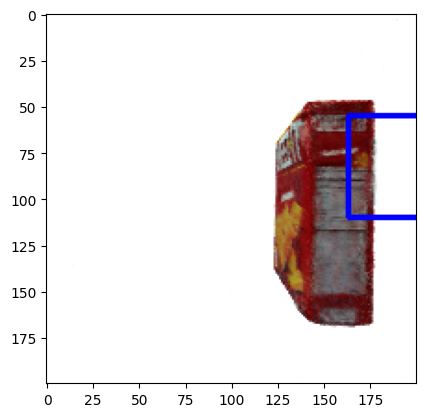

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.39797236944695236
[ 0.         43.80263773] [28.947366   87.69736621]


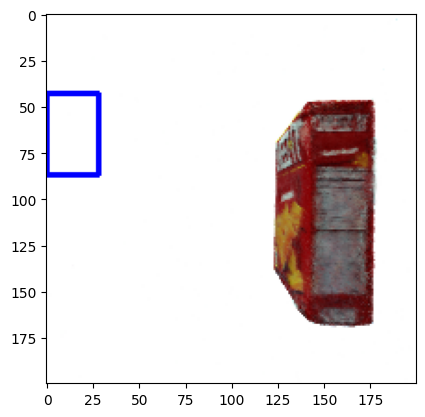

2.382173166646586e-05


In [45]:
grasp_poses, gg_pick_scores, grasp_cosine_scores = grasp_data[0], grasp_data[1], grasp_data[2]
cam_pose = pickle.load(open(f"/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_nnval_flip2/anygrasp_data_iter_15/c2w.pkl", 'rb'))
cam_pose_scaled = cam_pose.copy()
cam_pose_scaled[..., :3, 3] *= translation_scale.numpy()
cam_pose_scaled[..., :3, 3] += translation_offset.numpy()

images = np.zeros([5, H, W, 3])
projected_depths = np.zeros([5, H, W])
alphas = np.zeros([5, H, W])

fx, fy = 514.66662, 514.66662
cx, cy = 400, 400
for i, pipeline in enumerate(pipelines):
    camera = gen_camera(torch.tensor(cam_pose_scaled).cuda(), extra_args['focal'], W, H, z_far, extra_args)
    images[i], alpha, depth = get_image_with_depth(camera, pipeline)

    alphas[i] = alpha.squeeze()

    xmap, ymap = np.arange(depth.shape[1]), np.arange(depth.shape[0])
    xmap, ymap = np.meshgrid(xmap, ymap)
    angles = np.arctan(np.power(np.power(xmap - cx, 2) + np.power(ymap - cy, 2), 0.5)/fx)
    # bp()
    projected_depths[i] = depth * np.cos(angles)

alpha = alphas.mean(axis=0)
rgb_uncs = []
depth_uncs = []
# wf = open(f'{output_dump_dir}/grasp_scores.csv', 'w')
# wf.write('gg_pick_score,grasp_cosine_score,unc_rgb,unc_depth,gg/u_r,gg/u_d,gc/u_r,gc/u_d\n')
def point_to_pixel(p):
    fx, fy = 514.66662, 514.66662
    cx, cy = 400, 400
    x, y, z = p
    px = (cx + fx * x / z) / 4  # rendered images are already downsampled
    py = (cy + fy * y / z) / 4

    px = max(px, 0)
    py = max(py, 0)

    px = min(px, 799)
    py = min(py, 799)

    return np.array([px, py])
img_base = images[0].copy()
for i, grasp in enumerate(grasp_poses):
    grasp_orig = np.linalg.inv(cam_pose) @ grasp

    grasp_translation = grasp_orig[:3,-1] * [1,-1,-1]
    p1 = point_to_pixel(grasp_translation + np.array((-0.02,-0.02,0)))
    p2 = point_to_pixel(grasp_translation + np.array((0.02,0.02,0)))

    print(p1, p2)
    img_base2 = cv2.rectangle(img_base.copy(), (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (0,0,255), 2)
    # plt.imshow(images[0][int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])])
    plt.imshow(img_base2)
    plt.show()

    rgb_unc = np.var(images, axis=0).mean(axis=2)[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
    rgb_unc_std = rgb_unc.mean() ** 0.5

    depth_unc = np.var(projected_depths, axis=0)[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
    depth_unc_std = depth_unc.mean() ** 0.5

    alpha_mean = alpha[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])].mean()
    print(alpha_mean)
    rgb_uncs.append(rgb_unc_std)
    depth_uncs.append(depth_unc_std)
    # wf.write(f'{gg_pick_scores[i]},{grasp_cosine_scores[i]},{rgb_unc_std},{depth_unc_std},{gg_pick_scores[i]/rgb_unc_std},{gg_pick_scores[i]/depth_unc_std},{grasp_cosine_scores[i]/rgb_unc_std},{grasp_cosine_scores[i]/depth_unc_std}\n')

# wf.close()

gg_pick_scores = np.array(gg_pick_scores)
grasp_cosine_scores = np.array(grasp_cosine_scores)
rgb_uncs = np.array(rgb_uncs)
depth_uncs = np.array(depth_uncs)

g1_u_r = gg_pick_scores / rgb_uncs
g1_u_d = gg_pick_scores / depth_uncs
g2_u_r = grasp_cosine_scores / rgb_uncs
g2_u_d = grasp_cosine_scores / depth_uncs

gg_best = np.max(gg_pick_scores, initial=-1)
gc_best = np.max(grasp_cosine_scores, initial=-1)

rgb_unc_best = np.min(rgb_uncs, initial=np.inf)
depth_unc_best = np.min(depth_uncs, initial=np.inf)

g1_u_r_best = np.max(g1_u_r, initial=-1)
g1_u_d_best = np.max(g1_u_d, initial=-1)
g2_u_r_best = np.max(g2_u_r, initial=-1)
g2_u_d_best = np.max(g2_u_d, initial=-1)


In [107]:
x = np.argmax(g2_u_d)
x

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


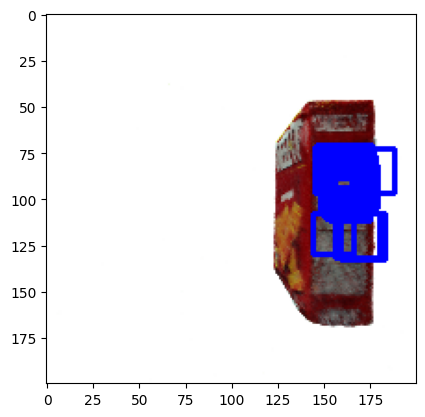

In [108]:
plt.imshow(img_base)

In [67]:
img_base

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

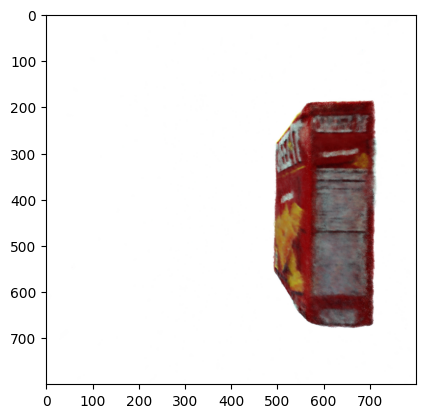

In [70]:
img_base.shape

(800, 800, 3)

In [1]:
r1 = 0.5
r2 = 1.5
num = 5000
u = np.random.uniform(np.power(r1, 3), np.power(r2, 3), num)
r = np.power(u, 1/3)
# r = np.random.uniform(r1, r2, num)
costheta = np.random.uniform(-1, 1, num)
theta = np.arccos(costheta)
phi = np.random.uniform(0, 2*np.pi, num)

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)



NameError: name 'np' is not defined

In [2]:

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',marker=dict(size=4))], layout=go.Layout(width=800, height=800))
fig.show()


NameError: name 'x' is not defined

In [32]:
from nba_utils import *

In [33]:
uniform_spherical_volume_sample(10, 1, 2)

array([[ 0.27246634,  1.84501307, -0.45758798],
       [ 1.65888788, -0.7466093 ,  0.18089463],
       [-0.43992684,  0.46083439,  0.89439644],
       [ 0.35997446,  0.07727661,  1.81314328],
       [ 1.28208725, -1.30328175, -0.70365789],
       [ 0.46099312,  0.63669168, -1.64827776],
       [ 0.53739221,  0.98005216, -1.49537499],
       [-0.62422071,  0.8663738 ,  0.59347818],
       [-0.31960544, -1.11049704,  0.57800028],
       [ 0.74849623,  0.90630887, -0.96673764]])